# EDA

## 결측치/이상치 탐지 및 처리(심화)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# 온라인 소매 데이터 생성 (컬럼명 소문자 버전)
np.random.seed(42)
n_customers = 1000

def create_realistic_ecommerce_data(n=1000):
    """실제와 유사한 전자상거래 데이터 생성 (소문자 컬럼명)"""
    
    data = {}
    
    # 고객 기본 정보
    data['customer_id'] = range(1, n+1)
    data['age'] = np.random.normal(35, 12, n).clip(18, 80).astype(int)
    data['gender'] = np.random.choice(['M', 'F'], n, p=[0.45, 0.55])
    data['city'] = np.random.choice(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju'], 
                                   n, p=[0.4, 0.2, 0.15, 0.15, 0.1])
    
    # 구매 행동 데이터
    data['total_purchases'] = np.random.poisson(8, n) + 1
    data['avg_order_value'] = np.random.lognormal(4.5, 0.8, n).round(2)
    data['days_since_last_purchase'] = np.random.exponential(30, n).astype(int)
    
    # 만족도 및 충성도
    data['satisfaction_score'] = np.random.normal(3.8, 1.2, n).clip(1, 5).round(1)
    data['loyalty_points'] = (data['total_purchases'] * data['avg_order_value'] * 0.1 + 
                             np.random.normal(0, 100, n)).clip(0, None).round(0)
    
    # 카테고리별 구매 금액
    categories = ['electronics', 'clothing', 'books', 'home', 'sports']
    for cat in categories:
        # 일부 고객은 특정 카테고리에서 구매하지 않음
        values = np.random.lognormal(3, 1, n)
        # 30% 확률로 해당 카테고리 구매 안 함 (0으로 설정)
        mask = np.random.random(n) < 0.3
        values[mask] = 0
        data[f'{cat}_spending'] = values.round(2)
    
    df = pd.DataFrame(data)
    
    # 의도적 결측값 생성 (실제 상황 모방)
    
    # 1. MCAR(Missing Completely at Random): 완전 무작위 결측 (시스템 오류)
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[missing_indices, 'satisfaction_score'] = np.nan
    
    # 2. MAR(Missing at Random): 조건부 결측 (나이가 높을수록 만족도 응답 거부율 증가)
    elderly_mask = df['age'] > 50
    elderly_missing = np.random.random(elderly_mask.sum()) < 0.15  
    elderly_indices = df[elderly_mask].index[elderly_missing]
    df.loc[elderly_indices, 'satisfaction_score'] = np.nan
    
    # 3. MNAR(Missing Not at Random): 비무작위 결측 - 결측 자체가 의미 (높은 소득자들이 개인정보 비공개)
    high_spenders = df['avg_order_value'] > df['avg_order_value'].quantile(0.8)
    high_spender_missing = np.random.random(high_spenders.sum()) < 0.25
    high_spender_indices = df[high_spenders].index[high_spender_missing]
    df.loc[high_spender_indices, 'age'] = np.nan
    
    # 도시 정보 일부 결측 (배송지 미입력)
    city_missing = np.random.choice(df.index, size=int(0.08 * len(df)), replace=False)
    df.loc[city_missing, 'city'] = np.nan
    
    # 의도적 이상값 생성
    
    # 1. 데이터 입력 오류 (나이 999살)
    error_indices = np.random.choice(df.index, size=3, replace=False)
    df.loc[error_indices, 'age'] = 999
    
    # 2. 비즈니스 이상값 (VIP 고객의 극도로 높은 구매액) Extreme but Valid Outliers
    vip_indices = np.random.choice(df.index, size=5, replace=False)
    df.loc[vip_indices, 'avg_order_value'] *= 20
    df.loc[vip_indices, 'loyalty_points'] *= 10
    
    # 3. 시스템 버그로 인한 음수값
    bug_indices = np.random.choice(df.index, size=2, replace=False) 
    df.loc[bug_indices, 'days_since_last_purchase'] = -1
    
    return df

# 데이터 생성
ecommerce = create_realistic_ecommerce_data(1000)

print("=== 온라인 소매 데이터 개요 ===")
print(f"데이터 크기: {ecommerce.shape}")
print("\n데이터 샘플:")
display(ecommerce.head(10))

print(f"\n기본 정보:")
print(ecommerce.info())

=== 온라인 소매 데이터 개요 ===
데이터 크기: (1000, 14)

데이터 샘플:


,customer_id,age,gender,city,total_purchases,avg_order_value,days_since_last_purchase,satisfaction_score,loyalty_points,electronics_spending,clothing_spending,books_spending,home_spending,sports_spending
0,1,40.0,M,Seoul,9,80.62,8,3.8,86.0,18.44,0.00,10.65,0.00,184.52
1,2,33.0,M,Seoul,9,27.69,4,2.0,0.0,46.54,0.00,210.79,17.13,20.43
2,3,42.0,F,Seoul,5,71.05,58,2.5,0.0,0.00,4.54,0.00,9.48,0.00
3,4,53.0,F,Seoul,11,158.62,24,1.8,318.0,26.55,25.55,3.49,5.04,41.76
4,5,32.0,M,Incheon,14,79.10,59,5.0,228.0,23.31,6.52,6.34,29.39,18.09
5,6,32.0,F,Busan,7,75.49,53,3.2,151.0,48.28,4.30,31.78,0.00,10.51
6,7,53.0,M,Busan,10,92.04,9,5.0,123.0,0.00,19.93,6.88,109.88,0.00
7,8,44.0,F,Seoul,10,95.80,23,1.0,135.0,37.61,23.63,24.12,13.02,0.00
8,9,29.0,F,Gwangju,10,156.80,2,5.0,76.0,24.55,18.20,20.30,3.03,13.65
9,10,41.0,F,Seoul,4,157.57,74,3.7,77.0,0.00,31.13,0.00,0.00,0.00



기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   int64  
 1   age                       944 non-null    float64
 2   gender                    1000 non-null   object 
 3   city                      920 non-null    object 
 4   total_purchases           1000 non-null   int32  
 5   avg_order_value           1000 non-null   float64
 6   days_since_last_purchase  1000 non-null   int64  
 7   satisfaction_score        934 non-null    float64
 8   loyalty_points            1000 non-null   float64
 9   electronics_spending      1000 non-null   float64
 10  clothing_spending         1000 non-null   float64
 11  books_spending            1000 non-null   float64
 12  home_spending             1000 non-null   float64
 13  sports_spending           1000 non-null   float64
dtypes

In [2]:
# 데이터 전반적인 상태 점검 - da_utils/profile.py 모듈(파일) 안의 get_data_profile 함수를 가져옴
from da_utils.profile import get_data_profile # 바로 get_data_profile 함수를 꺼냈음
# from da_utils import profile                # profile 모듈 전체를 꺼내서 실제로 사용할 때는 profile.get_data_profile 로 사용해야 함

data_report = get_data_profile(ecommerce)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 1000행 x 14열
- 메모리 사용량: 0.19mb
- 수치형 변수: 12개
- 범주형 변수: 2개

2. 결측값 분석
⚠️


,결측수,결측률(%)
age,56,5.6
city,80,8.0
satisfaction_score,66,6.6



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,customer_id,500.500,288.819,1.00,1000.00,0.000,-1.200,0.000,100.000
1,age,38.090,55.408,18.00,999.00,16.626,286.612,1.059,5.508
2,total_purchases,8.937,2.630,2.00,17.00,0.227,-0.097,0.000,1.600
3,avg_order_value,128.624,185.100,8.05,3603.40,11.637,196.193,7.000,97.900
4,days_since_last_purchase,29.863,30.656,-1.00,191.00,1.688,3.301,4.800,13.300
5,satisfaction_score,3.673,1.067,1.00,5.00,-0.506,-0.586,0.000,4.390
6,loyalty_points,131.534,158.522,0.00,1640.00,3.606,23.761,3.700,34.300
7,electronics_spending,22.506,35.498,0.00,545.10,5.302,54.688,6.300,67.000
8,clothing_spending,23.553,42.124,0.00,877.86,9.838,175.613,6.200,67.600
9,books_spending,25.777,40.763,0.00,468.20,3.898,23.960,7.100,66.400



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- age: 왜도 = 16.626
-- avg_order_value: 왜도 = 11.637
-- loyalty_points: 왜도 = 3.606
-- electronics_spending: 왜도 = 5.302
-- clothing_spending: 왜도 = 9.838
-- books_spending: 왜도 = 3.898
-- home_spending: 왜도 = 3.685
-- sports_spending: 왜도 = 9.004

- 높은 이상값 비율(>5%)
⚠️
-- avg_order_value: 이상값 7.0%
-- electronics_spending: 이상값 6.3%
-- clothing_spending: 이상값 6.2%
-- books_spending: 이상값 7.1%
-- home_spending: 이상값 7.6%
-- sports_spending: 이상값 7.4%


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
city,80,8.0
satisfaction_score,66,6.6
age,56,5.6


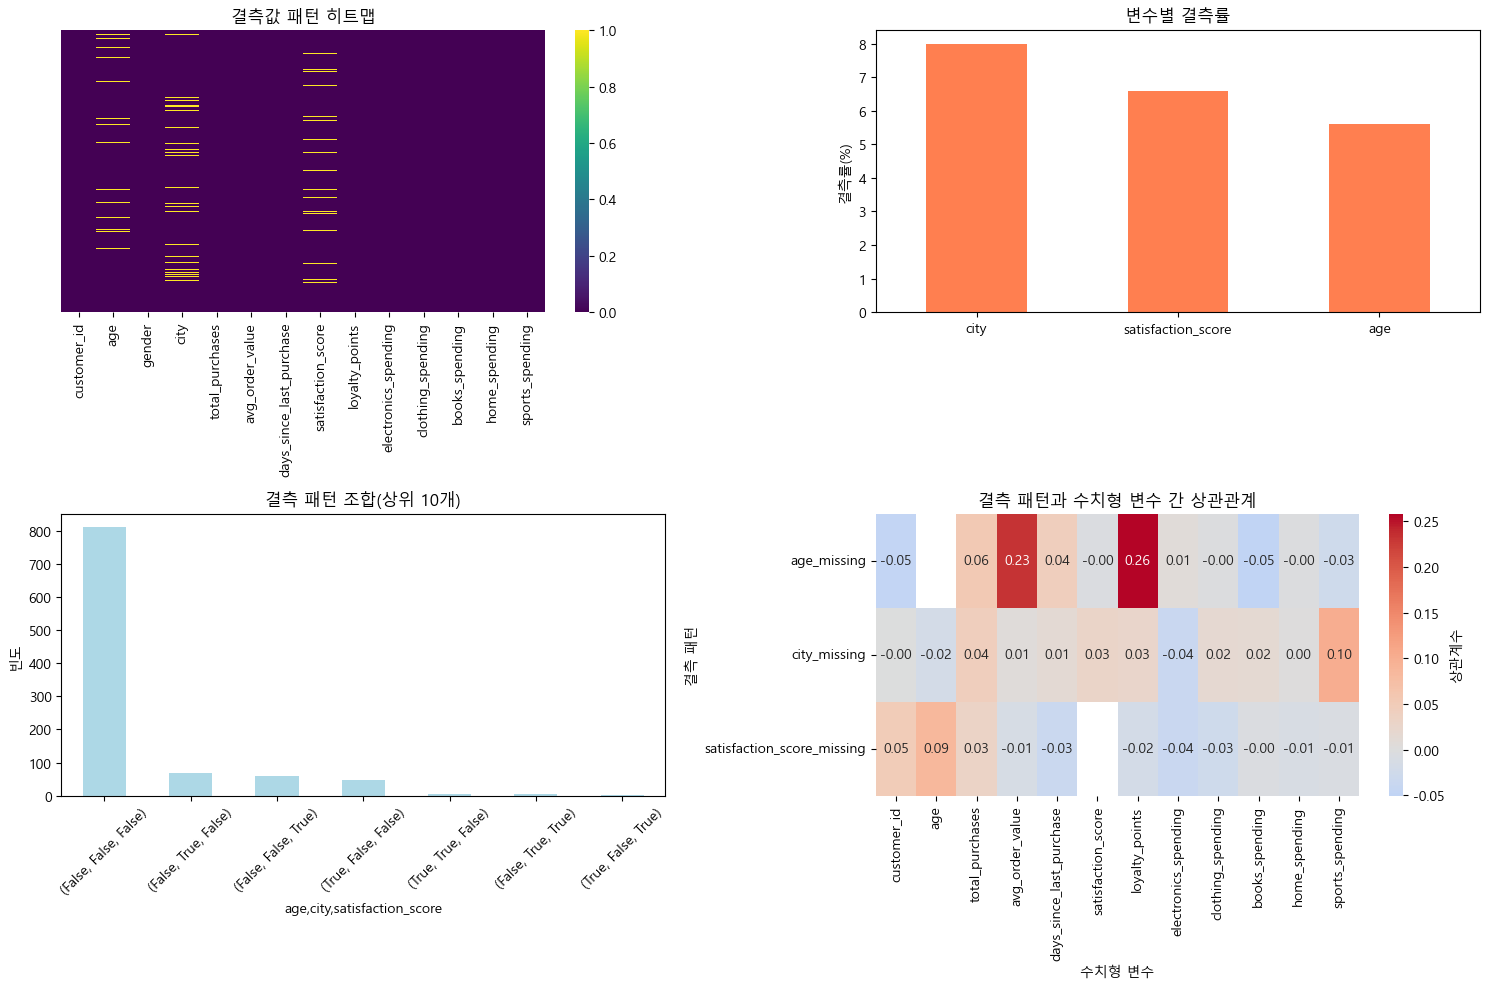

In [3]:
# 결측치 패턴 분석

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def analyze_missing_patterns(df: pd.DataFrame):
    """결측값 패턴 종합 분석"""
    
    print('=== 결측값 패턴 분석 ===')
    missing_info = df.isna().sum()
    missing_pct = (missing_info / len(df)) * 100
    missing_summary = pd.DataFrame({
        '결측수': missing_info,
        '결측률(%)': missing_pct.round(2),
    })
    missing_summary = missing_summary[missing_summary['결측수'] > 0].sort_values('결측수', ascending=False)
    print('변수별 결측 현황')
    display(missing_summary)
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
    
    # 1. 결측값 히트맵
    sns.heatmap(df.isna(), yticklabels=False, cbar=True, cmap='viridis', ax=a1)
    a1.set_title('결측값 패턴 히트맵')
    
    # 2. 변수별 결측률 바 차트
    if len(missing_summary) > 0:  # >0은 생략 가능(내용이 있다면)
        missing_summary['결측률(%)'].plot(kind='bar', color='coral', ax=a2)
        a2.set_title('변수별 결측률')    
        a2.set_ylabel('결측률(%)')
        a2.tick_params(axis='x', rotation=0)
    
    # 3. 결측값 조합 패턴 - 결측이 동시에 발생하는 변수 파악 후 유의미하게 많으면 연관을 생각할 수 있음 -> 4번에서 그룹별로 처리 가능
    '''
    df.isna().any()                           -> 컬럼에 결측값이 있으면 True, 없으면 False
    df.columns[df.isna().any()]               -> 결측값이 있는 컬럼명을 추출
    df[df.columns[df.isna().any()]]           -> 결측값이 있는 컬럼의 전체값을 추출함
    df[df.columns[df.isna().any()]].isna()    -> 결측값이라면 True로 설정함
    결측값이 있는 age, city, satisfaction_score 간에 어떤 조합이 가장 많은지 파악
    '''
    missing_pattern = df[df.columns[df.isna().any()]].isna()
    if len(missing_pattern):
        pattern_counts = missing_pattern.value_counts().head(10)
        pattern_counts.plot(kind='bar', color='lightblue', ax=a3)
        a3.set_title('결측 패턴 조합(상위 10개)')
        a3.set_ylabel('빈도')
        a3.tick_params(axis='x', rotation=45)


    # 4. 결측 변수별 결측 여부(0/1)와 다른 수치형 변수 간 상관관계 히트맵 시각화
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    missing_cols = df.columns[df.isna().any()].tolist()

    if len(numeric_cols) > 0 and len(missing_cols) > 0:
        # 결측값을 0/1로 변환한 DataFrame 생성
        missing_binary = df[missing_cols].isna().astype(int)
        missing_binary.columns = [f'{col}_missing' for col in missing_binary.columns]
        
        # 수치형 변수와 결측 패턴 변수 결합
        corr_data = pd.concat([df[numeric_cols], missing_binary], axis=1)
        
        # 상관계수 계산
        correlation_matrix = corr_data.corr()
        
        # 결측 패턴 변수와 수치형 변수 간의 상관관계만 추출
        missing_numeric_corr = correlation_matrix.loc[
            missing_binary.columns, 
            numeric_cols
        ]
        
        # 상관관계가 있는 경우에만 히트맵 그리기
        if missing_numeric_corr.shape[0] > 0 and missing_numeric_corr.shape[1] > 0:
            sns.heatmap(
                    missing_numeric_corr, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    fmt='.2f',
                    ax=a4,
                    cbar_kws={'label': '상관계수'},
                )
            a4.set_title('결측 패턴과 수치형 변수 간 상관관계')
            a4.set_xlabel('수치형 변수')
            a4.set_ylabel('결측 패턴')
        else:
            a4.text(0.5, 0.5, '분석할 상관관계 없음', ha='center', va='center')
            a4.axis('off')
    else:
        a4.text(0.5, 0.5, '수치형 변수 또는\n결측값이 없음', ha='center', va='center')
        a4.axis('off')

    
    plt.tight_layout()
    plt.show()
    
analyze_missing_patterns(ecommerce)

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
city,80,8.0
satisfaction_score,66,6.6
age,56,5.6


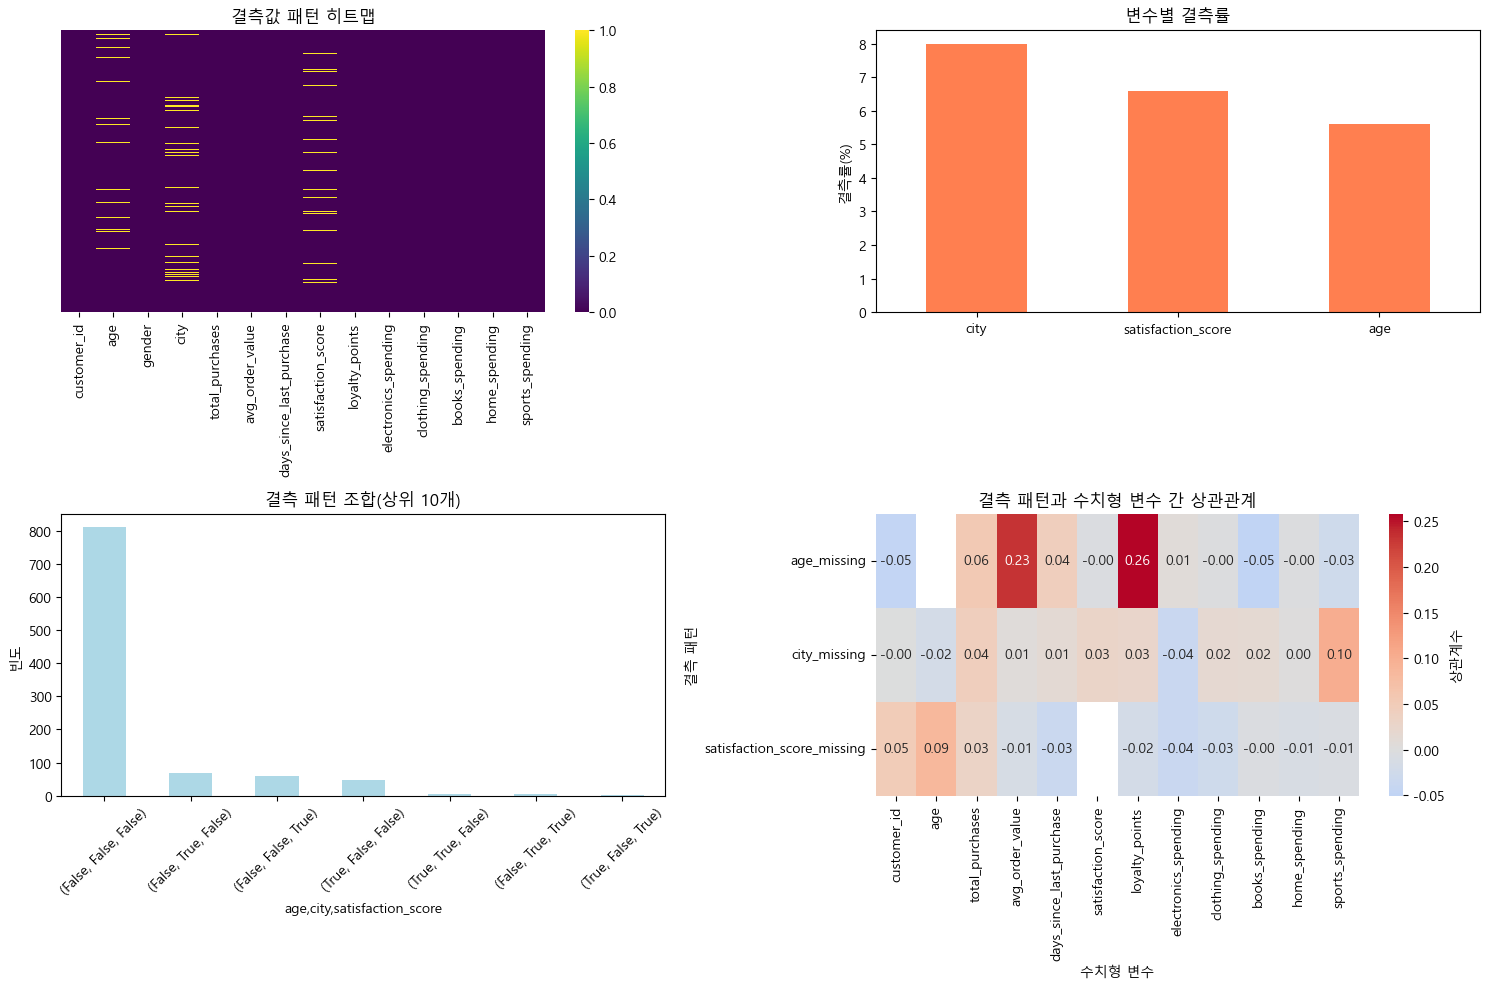

In [4]:
# 파이썬 모듈에서 불러오기

from da_utils.patterns import analyze_missing_patterns
analyze_missing_patterns(ecommerce)

In [5]:
# 결측 메커니즘 진단
from scipy.stats import chi2_contingency


print('=== 결측 메커니즘 진단 ===')

# MAR(조건부) 패턴
# 가설: 나이 결측과 구매액 간 관계
if ecommerce['age'].isna().sum():
    print('\n1. 나이(age) 결측 메커니즘 분석')

    # 구매액 분위별 나이 결측률
    df_temp = ecommerce.copy()
    df_temp['spending_quertile'] = pd.qcut(df_temp['avg_order_value'].dropna(), q=4, labels=['4분위', '3분위', '2분위', '1분위'])
    age_missing_by_spending = df_temp.groupby('spending_quertile')['age'].apply(lambda x: x.isnull().mean())  # 분위별로 그룹을 짓고, 그룹별로 각 값에 isnull(T/F로 변환)을 적용 후 평균(T/F는 1/0)을 계산
    print('\n 💲구매액 분위별 나이 결측률')
    for key, value in age_missing_by_spending.items():
        print(f' {key}: {value:.1%}')
        
    con_table = pd.crosstab(df_temp['spending_quertile'], df_temp['age'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    # print(f'\n카이^2 통계량: {chi2:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print(' ✅MAR 확인: 구매액에 따라 나이 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 구매액과 나이 결측률은 서로 독립적')

else:
    print(' 나이(age) 결측 없음')
    
    
# 만족도 결측 패턴 분석
print('\n2. 만족도(satisfaction_score) 결측 메커니즘 분석')

if ecommerce['satisfaction_score'].isna().sum():
    # 연령대별 만족도 결측률 [0, 30, 50, 100] - [청년층(~30), 중년층(31~50), 노년층(51~)]
    # 각 구간마다 만족도가 없는 사람들의 %를 구해서 print
    print('\n 🧓연령별 만족도 결측률')
    df_temp = ecommerce.copy()
    df_temp['age_group'] = pd.cut(df_temp['age'].dropna(), bins=[0, 30, 50, 200], labels=['청년층', '중년층', '노년층'])
    satisfaction_missing_by_age = df_temp.groupby('age_group')['satisfaction_score'].apply(lambda x: x.isnull().sum() / len(x))

    for key, value in satisfaction_missing_by_age.items():
        print(f' {key}: {value:.1%}')

    con_table = pd.crosstab(df_temp['age_group'], df_temp['satisfaction_score'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    if p_value < 0.05:
        print(' ✅MAR 확인: 연령에 따라 만족도 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 연령과 만족도 결측률은 서로 독립적')


    # 성별별 만족도 결측률도
    print('\n ♂️성별별 만족도 결측률')

    df_temp = ecommerce.copy()
    satisfaction_missing_by_gender = df_temp.groupby('gender')['satisfaction_score'].apply(lambda x: x.isnull().sum() / len(x))

    for key, value in satisfaction_missing_by_gender.items():
        print(f' {key}: {value:.1%}')


    con_table = pd.crosstab(df_temp['gender'], df_temp['satisfaction_score'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    if p_value < 0.05:
        print(' ✅MAR 확인: 성별에 따라 만족도 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 성별과 만족도 결측률은 서로 독립적')
        
else:
    print(' 만족도 결측 없음')

=== 결측 메커니즘 진단 ===

1. 나이(age) 결측 메커니즘 분석

 💲구매액 분위별 나이 결측률
 4분위: 0.0%
 3분위: 0.0%
 2분위: 0.0%
 1분위: 22.4%
 ✅MAR 확인: 구매액에 따라 나이 결측률이 유의미하게 다름

2. 만족도(satisfaction_score) 결측 메커니즘 분석

 🧓연령별 만족도 결측률
 청년층: 4.0%
 중년층: 5.8%
 노년층: 20.4%
 ✅MAR 확인: 연령에 따라 만족도 결측률이 유의미하게 다름

 ♂️성별별 만족도 결측률
 F: 5.6%
 M: 7.9%
 ❌MCAR 가능성 있음: 성별과 만족도 결측률은 서로 독립적


## 고급 결측값 대체 기법

원본데이터 결측률
  age: 5.60%
  satisfaction_score: 6.60%


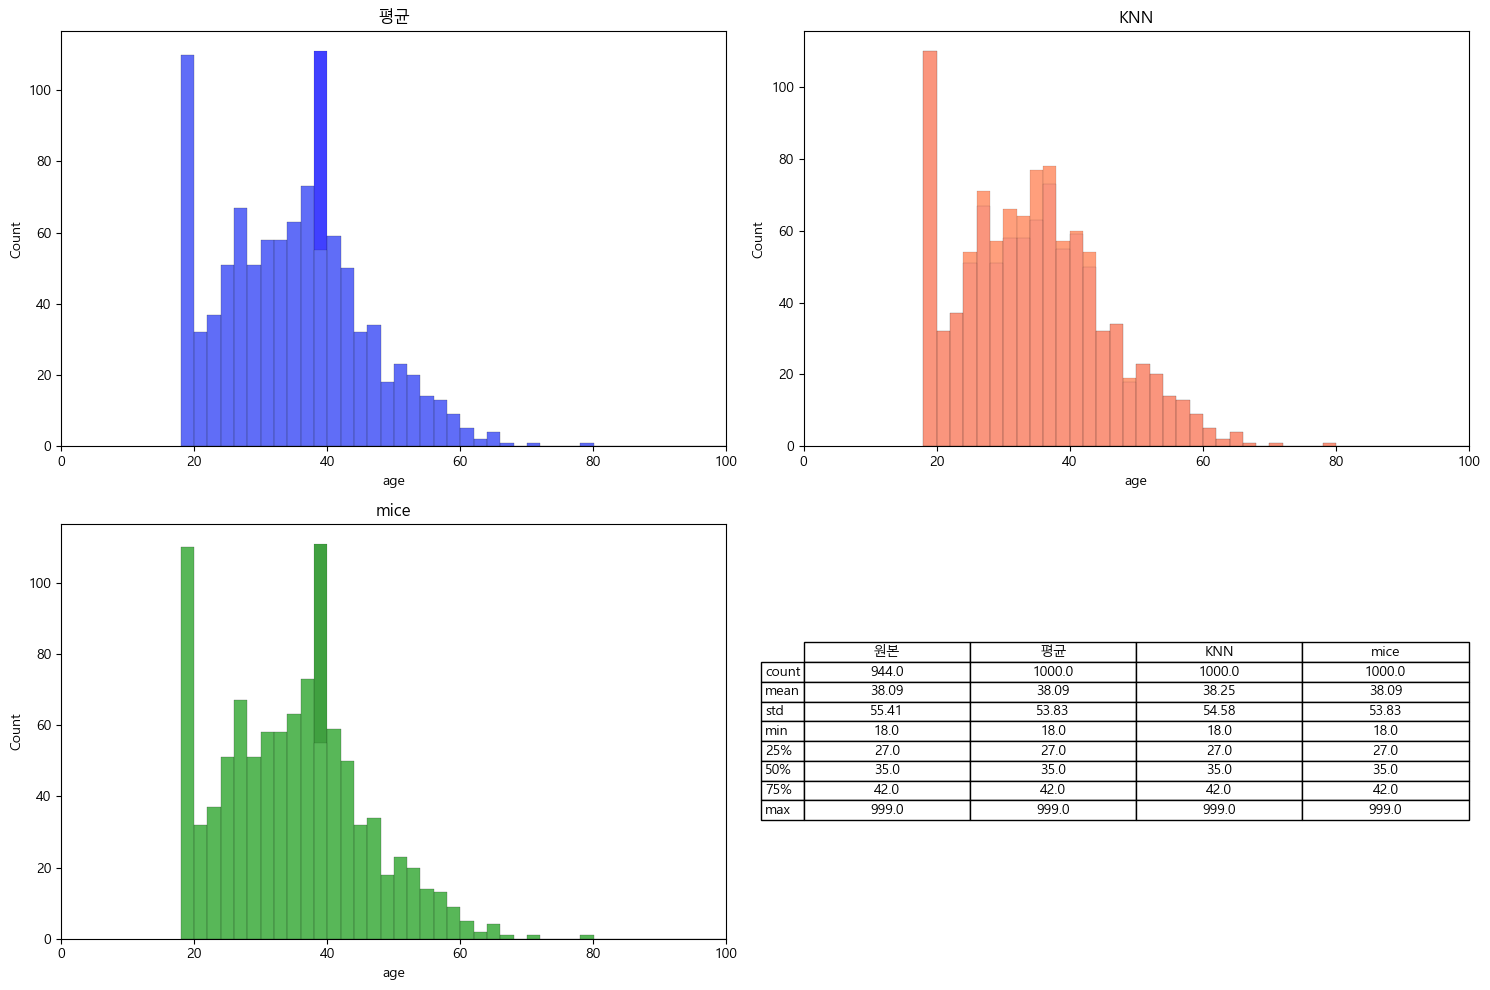

In [6]:
# impute: 대체하다
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 숫자형 컬럼만 뽑기
numeric_cols = ['age', 'total_purchases', 'avg_order_value', 'days_since_last_purchase', 'satisfaction_score']
df_numeric = ecommerce[numeric_cols]
print('원본데이터 결측률')
for col in numeric_cols:
    missing_rate = df_numeric[col].isnull().mean()
    if missing_rate:
        print(f'  {col}: {missing_rate:.2%}')

# 1. 결측에 전부 평균을 집어넣었음
imputer_mean = SimpleImputer(strategy='mean')
df_mean = df_numeric.copy()
df_mean[numeric_cols] = imputer_mean.fit_transform(df_numeric[numeric_cols])


# 2. KNN 대체 - K Nearest Neighbors, 결측값과 가장 가까운 n명을 뽑아서 그 사람들의 평균을 구함
imputer_knn = KNNImputer(n_neighbors=5)
df_knn = df_numeric.copy()
df_knn[numeric_cols] = imputer_knn.fit_transform(df_numeric[numeric_cols])


# 3. MICE 대체 - Multiple Imputation by Chained Equations, 결측변수를 다른 변수를 써서 회귀모델 예측
imputer_mice = IterativeImputer(random_state=42, max_iter=10)
df_mice = df_numeric.copy()
df_mice[numeric_cols] = imputer_mice.fit_transform(df_numeric[numeric_cols])

# age 변수의 대체결과 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15,10))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

variable = 'age'
if df_numeric[variable].isnull().sum():
    
    sns.histplot(df_mean[variable], binwidth=2, kde=False, ax=a1, label='평균', color='blue')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a1, label='원본', color='lightblue', alpha=0.3)
    a1.set_xlim(0, 100)
    a1.set_title('평균')
        
    sns.histplot(df_knn[variable], binwidth= 2, kde=False, ax=a2, label = 'KNN', color='coral')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a2, label='원본', color='lightcoral', alpha=0.3)
    a2.set_xlim(0, 100)
    a2.set_title('KNN')

    sns.histplot(df_mice[variable], binwidth= 2, kde=False, ax=a3, label = 'mice', color='green')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a3, label='원본', color='lightgreen', alpha=0.3)
    a3.set_xlim(0, 100)
    a3.set_title('mice')
    
    
    # 대체 전후 통계량 비교
    comparison_stats = pd.DataFrame({
        '원본': df_numeric[variable].describe(),
        '평균': df_mean[variable].describe(),
        'KNN': df_knn[variable].describe(),
        'mice': df_mice[variable].describe(),
    }).round(2)
    
    # 텍스트로 통계 비교 표시
    a4.axis('off')
    a4.table(
        cellText=comparison_stats.values,
        rowLabels=comparison_stats.index,
        colLabels=comparison_stats.columns,
        cellLoc='center',
        loc='center',
    )
    
    plt.tight_layout()
    plt.show()

## 대체 품질 평가

In [7]:
print('=== 대체 품질 평가 ===')
dist_evaluation_results = []
corr_evaluation_results = []
original_df = df_numeric
imputed_dfs = [df_mean, df_knn, df_mice ]
method_names = ['평균대체', 'KNN대체', 'MICE대체']

for method_name, imputed_df in zip(method_names, imputed_dfs):
    
    for col in ['age','satisfaction_score']:
        # 1. 분포 유사성 평가
        # 결측치가 있는 경우만
        if original_df[col].isnull().sum():
            
            original_stats = original_df[col].dropna().describe()
            imputed_stats = imputed_df[col].describe()
            
            # 평균차이
            mean_diff = abs(original_stats['mean'] - imputed_stats['mean']) / original_stats['mean'] * 100
            # 표준편차차이
            std_diff = abs(original_stats['std'] - imputed_stats['std']) / original_stats['std'] * 100
            
            dist_evaluation_results.append({
                '방법': method_name,
                '변수': col,
                '평균차이(%)': mean_diff,
                '표준편차차이(%)': std_diff,
            })

        # 2. 다른 변수와의 상관관계 보존 평가 - age, satisfaction_score <-> average_order_value
        # 이건 실제로 상관관계가 있는 걸로 평가해야 함
            original_corr = original_df[[col, 'avg_order_value']].corr().iloc[0, 1]  # 결측치 포함
            imputed_corr = imputed_df[[col, 'avg_order_value']].dropna().corr().iloc[0, 1]  # 결측치 대체
        
            # 상관관계 유지도
            corr_preservation = abs(original_corr - imputed_corr) / abs(original_corr) * 100
            
            corr_evaluation_results.append({
                '방법': method_name,
                '변수': f'{col}-구매액 상관관계',
                '원본상관계수': original_corr,
                '대체상관계수': imputed_corr,
                '상관계수보존도(%)': 100 - corr_preservation,
            })
        
print('\n1. 분포 보존 성능')
dist_eval = pd.DataFrame(dist_evaluation_results) 
display(dist_eval)

print('\n2. 상관관계 보존 성능')
corr_eval = pd.DataFrame(corr_evaluation_results)
for _, row in corr_eval.iterrows():
    print(f'{row['방법']}: 보존도 {row['상관계수보존도(%)']:.1f}%')
    print(f'(원본: {row['원본상관계수']:.3f} → 대체후: {row['대체상관계수']:.3f})')

=== 대체 품질 평가 ===

1. 분포 보존 성능


,방법,변수,평균차이(%),표준편차차이(%)
0,평균대체,age,1.865429e-14,2.843222
1,평균대체,satisfaction_score,0.000000e+00,3.359743
2,KNN대체,age,4.283472e-01,1.495421
3,KNN대체,satisfaction_score,2.062418e-01,2.573274
4,MICE대체,age,8.844091e-04,2.843222
5,MICE대체,satisfaction_score,1.262428e-02,3.351658



2. 상관관계 보존 성능
평균대체: 보존도 94.9%
(원본: -0.000 → 대체후: -0.000)
평균대체: 보존도 98.9%
(원본: -0.046 → 대체후: -0.045)
KNN대체: 보존도 -550.6%
(원본: -0.000 → 대체후: -0.003)
KNN대체: 보존도 98.6%
(원본: -0.046 → 대체후: -0.046)
MICE대체: 보존도 98.0%
(원본: -0.000 → 대체후: -0.000)
MICE대체: 보존도 98.7%
(원본: -0.046 → 대체후: -0.046)


## 이상값 탐지 및 처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 경고메세지 무시
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# 범용 이상치 탐지 함수
def outlier_detection(df: pd.DataFrame):
    print('=== 종합 이상값 탐지 ===')
    df_copy = df.copy()
    
    # 1. IQR 이상값(일(단)변량 이상값 탐지) - 변수 하나를 가지고 확인
        # 특정 컬럼 안에서 다른 값들에 비해 값이 이상한 걸 탐지함
    print('1. 일변량 이상값 탐지(IQR법)')
    univariate_outliers = pd.DataFrame(index=df_copy.index)
    for col in df_copy.select_dtypes(include=['number']).columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)
        univariate_outliers[col] = outliers_mask
        
        outlier_count = outliers_mask.sum()
        if outlier_count:
            print(f'  {col}: {outlier_count}개 ({outlier_count/len(df_copy) * 100:.1f}%)')

    # 2. 마할라노비스 거리 기반 다변량 이상값
        # 변수 간의 스케일 차이와 상관관계까지 고려해 이상값을 확인
    print('2. 마할라노비스 거리 기반 다변량 이상값 탐지')
    







outlier_detection(ecommerce)

=== 종합 이상값 탐지 ===
1. 일변량 이상값 탐지(IQR법)
  age: 10개 (1.0%)
  avg_order_value: 70개 (7.0%)
  days_since_last_purchase: 48개 (4.8%)
  loyalty_points: 37개 (3.7%)
  electronics_spending: 63개 (6.3%)
  clothing_spending: 62개 (6.2%)
  books_spending: 71개 (7.1%)
  home_spending: 76개 (7.6%)
  sports_spending: 74개 (7.4%)
